In [3]:
import os
import logging
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaModel,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    PreTrainedModel,
    RobertaConfig
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger("bug_localiser")

# Disable parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
data_path = "../../Data/SSTUBS_ENHANCED_23MAR"
dataset = load_dataset("json", data_files={
    "train": f"{data_path}/train.json",
    "validation": f"{data_path}/val.json",
    "test": f"{data_path}/test.json"
})


In [5]:
model_name = "microsoft/codebert-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

special_tokens = {
    "additional_special_tokens": ["[CONTEXT]", "[SNIPPET]", "[COMMIT]", "[PARENT]"]
}
tokenizer.add_special_tokens(special_tokens)

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding=False)

tokenised_dataset = dataset.map(preprocess, batched=True)


/home/olan_healy/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
class CustomRobertaClassifier(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.roberta.resize_token_embeddings(len(tokenizer))
        for param in self.roberta.parameters():
            param.requires_grad = False  # freeze the entire encoder

        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, config.num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

model = CustomRobertaClassifier(RobertaConfig.from_pretrained(model_name, num_labels=2)).to(device)


/home/olan_healy/anaconda3/lib/python3.11/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, 

In [ ]:
class MultiEvalTrainer(Trainer):
    def __init__(self, *args, eval_datasets=None, **kwargs):
        if eval_datasets and len(eval_datasets) > 0:
            kwargs["eval_dataset"] = eval_datasets[0]  
        super().__init__(*args, **kwargs)
        self.eval_datasets = eval_datasets or []

    def _compute_metrics_with_prefix(self, pred, prefix):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
        acc = accuracy_score(labels, preds)
        return {
            f"{prefix}_accuracy": acc,
            f"{prefix}_precision": precision,
            f"{prefix}_recall": recall,
            f"{prefix}_f1": f1,
        }

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        if eval_dataset is None and self.eval_datasets:
            results = {}
            for i, eval_ds in enumerate(self.eval_datasets):
                prefix = f"{metric_key_prefix}_dataset_{i + 1}"
                logger.info(f"Evaluating dataset {i + 1} with prefix '{prefix}'...")
                eval_output = self.predict(eval_ds, ignore_keys=ignore_keys)
                results.update(self._compute_metrics_with_prefix(eval_output, prefix))
            return results
        return super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)


In [ ]:
# small balanced validation set from the training set
tokenised_dataset["train_val"] = tokenised_dataset["train"].shuffle(seed=42).select(range(min(500, len(tokenised_dataset["train"]))))
tokenised_dataset["validation"] = tokenised_dataset["validation"].shuffle(seed=42).select(range(min(500, len(tokenised_dataset["validation"]))))


In [ ]:
training_args = TrainingArguments(
    output_dir="../../FINAL_MODEL_LARGER_HEAD",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_strategy="steps",            
    logging_steps=500,                   
    save_strategy="steps",
    save_steps=500,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_dataset_1_f1",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none",
)

In [ ]:
trainer = MultiEvalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenised_dataset["train"],
    eval_datasets=[tokenised_dataset["train_val"], tokenised_dataset["validation"]],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
)


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


 Final Test Set Metrics:
eval_loss: 0.5301
eval_runtime: 21.5652
eval_samples_per_second: 467.4200
eval_steps_per_second: 14.6070


In [10]:
logger.info("Training started...")
trainer.train()

2025-03-24 19:58:13,473 - INFO - Training started...
/home/olan_healy/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/olan_healy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss


2025-03-24 19:59:27,010 - INFO - Evaluating dataset 1 with prefix 'eval_dataset_1'...
2025-03-24 19:59:29,276 - INFO - Evaluating dataset 2 with prefix 'eval_dataset_2'...
/home/olan_healy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/olan_healy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
2025-03-24 20:00:45,108 - INFO - Evaluating dataset 1 with prefix 'eval_dataset_1'...
2025-03-24 20:00:47,475 - INFO - Evaluating dataset 2 with prefix 'eval_dataset_2'...
/home/olan_healy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were sca

TrainOutput(global_step=253250, training_loss=0.6287362824540736, metrics={'train_runtime': 23340.3762, 'train_samples_per_second': 173.579, 'train_steps_per_second': 10.85, 'total_flos': 3.9528405854463565e+17, 'train_loss': 0.6287362824540736, 'epoch': 50.0})

In [ ]:
from transformers import RobertaConfig, RobertaTokenizerFast


checkpoint_path = "../../FINAL_MODEL_LARGER_HEAD/checkpoint-235500"
config = RobertaConfig.from_pretrained(checkpoint_path)

tokenizer = RobertaTokenizerFast.from_pretrained(checkpoint_path)

model = CustomRobertaClassifier(config)
model.load_state_dict(torch.load(f"{checkpoint_path}/pytorch_model.bin"))
model.to(device)


/home/olan_healy/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/olan_healy/anaconda3/lib/python3.11/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted 

CustomRobertaClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50269, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

In [ ]:
import json
import pandas as pd

trainer_state_path = "../../FINAL_MODEL_LARGER_HEAD/checkpoint-235500/trainer_state.json"

with open(trainer_state_path) as f:
    state = json.load(f)

log_history = state["log_history"]
log_df = pd.DataFrame(log_history)

log_df.to_csv("recovered_training_logs.csv", index=False)

log_df.tail(10)


,epoch,learning_rate,loss,step
461,45.61,0.000002,0.6164,231000
462,45.71,0.000002,0.6204,231500
463,45.80,0.000002,0.6140,232000
464,45.90,0.000002,0.6157,232500
465,46.00,0.000002,0.6121,233000
466,46.10,0.000002,0.6194,233500
467,46.20,0.000002,0.6141,234000
468,46.30,0.000001,0.6149,234500
469,46.40,0.000001,0.6178,235000
470,46.50,0.000001,0.6195,235500


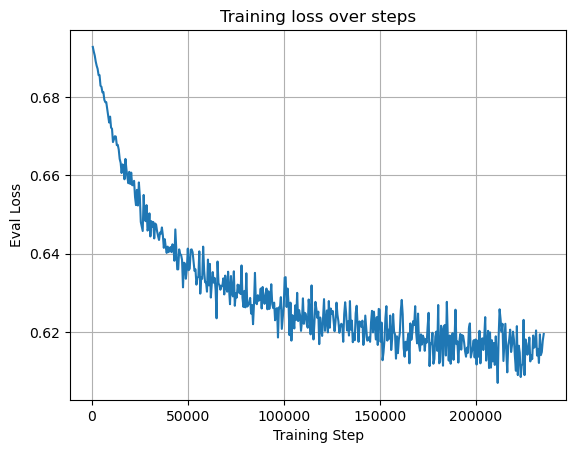

In [23]:
import matplotlib.pyplot as plt

log_df = pd.read_csv("recovered_training_logs.csv")

plt.plot(log_df["step"], log_df["loss"])
plt.xlabel("Training Step")
plt.ylabel("Eval Loss")
plt.title("Training loss over steps")
plt.grid(True)
plt.show()


In [22]:
print(log_df.columns)

Index(['epoch', 'learning_rate', 'loss', 'step'], dtype='object')


In [ ]:
# Reattach trainer to reloaded model
trainer.model = model  

# Evaluate on both sets
logger.info("Re-evaluating on train_val and validation sets...")
results = trainer.evaluate()

# Print results nicely
print(" Final Evaluation Metrics:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


2025-03-25 11:19:43,188 - INFO - 🔍 Re-evaluating on train_val and validation sets...
2025-03-25 11:19:43,191 - INFO - Evaluating dataset 1 with prefix 'eval_dataset_1'...
/home/olan_healy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


2025-03-25 11:19:46,255 - INFO - Evaluating dataset 2 with prefix 'eval_dataset_2'...
/home/olan_healy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


 Final Evaluation Metrics:
eval_dataset_1_accuracy: 0.7540
eval_dataset_1_precision: 0.7302
eval_dataset_1_recall: 0.8088
eval_dataset_1_f1: 0.7675
eval_dataset_2_accuracy: 0.7760
eval_dataset_2_precision: 0.7472
eval_dataset_2_recall: 0.8204
eval_dataset_2_f1: 0.7821
